# House Prices - Advanced Regression Techniques

## Giới thiệu
Bộ dữ liệu **Ames Housing** được thu thập tại **thành phố Ames, bang Iowa (Mỹ)**, mô tả chi tiết các căn nhà được bán trong giai đoạn **2006–2010**.  
Biến mục tiêu là **`SalePrice`** – giá bán của căn nhà (USD).  

Mục tiêu của bài toán:

> Dự đoán giá bán (`SalePrice`) dựa trên các đặc điểm vật lý, vị trí, và điều kiện của ngôi nhà.

### Import thư viện

In [173]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

### Load dữ liệu

In [174]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

test_ID = test_df['Id']

## Exploratory Data Analysis - EDA

### Tổng quan dữ liệu

In [175]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Bộ dữ liệu **Ames Housing** gồm:
- **1460 dòng (mẫu nhà)**  
- **81 cột (biến đặc trưng)**

→ Trong đó, **biến mục tiêu (target)** là `SalePrice` — giá bán của ngôi nhà (USD).

In [176]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Tóm tắt thông tin các feature

In [177]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [178]:
test_df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


🎯 Biến mục tiêu:
- `SalePrice`: Giá bán của căn nhà → Đây là biến mục tiêu cần dự đoán.

🏠 Thông tin tổng quan về nhà và khu đất:
- `MSSubClass`: Loại công trình
- `MSZoning`: Phân khu quy hoạch chung
- `LotFrontage`: Chiều dài mặt tiền giáp đường (tính bằng feet)
- `LotArea`: Diện tích lô đất (tính bằng feet vuông)
- `Street`: Loại đường tiếp cận
- `Alley`: Loại hẻm hoặc lối đi phía sau nhà
- `LotShape`: Hình dạng tổng thể của lô đất
- `LandContour`: Độ bằng phẳng của khu đất
- `Utilities`: Các loại tiện ích có sẵn (điện, nước, gas,...)
- `LotConfig`: Cấu hình của lô đất
- `LandSlope`: Độ dốc của khu đất
- `Neighborhood`: Khu phố hoặc vùng lân cận trong thành phố Ames
- `Condition1`: Vị trí so với đường chính hoặc đường sắt
- `Condition2`: Vị trí so với đường chính hoặc đường sắt

🏗️ Kiểu nhà và phong cách xây dựng
- `BldgType`: Loại hình nhà
- `HouseStyle`: Kiểu thiết kế của căn nhà
- `OverallQual`: Đánh giá tổng thể về chất lượng vật liệu và hoàn thiện
- `OverallCond`: Đánh giá tổng thể về tình trạng bảo trì, sửa chữa
- `YearBuilt`: Năm xây dựng ban đầu
- `YearRemodAdd`: Năm tu sửa hoặc mở rộng gần nhất

🧱 Vật liệu và kết cấu bên ngoài
- `RoofStyle`: Kiểu mái
- `RoofMatl`: Vật liệu làm mái
- `Exterior1st`: Vật liệu ốp tường bên ngoài (lớp thứ nhất)
- `Exterior2nd`: Vật liệu ốp tường bên ngoài (lớp thứ hai, nếu có)
- `MasVnrType`: Loại vật liệu ốp tường bằng đá/gạch (veneer)
- `MasVnrArea`: Diện tích tường ốp veneer (tính bằng feet vuông)
- `ExterQual`: Chất lượng vật liệu bên ngoài
- `ExterCond`: Tình trạng vật liệu bên ngoài

🏚️ Nền móng và tầng hầm
- `Foundation`: Loại móng nhà
- `BsmtQual`: Chiều cao tầng hầm
- `BsmtCond`: Tình trạng tầng hầm
- `BsmtExposure`: Mức độ thông thoáng
- `BsmtFinType1`: Chất lượng phần tầng hầm đã hoàn thiện (loại 1)
- `BsmtFinSF1`: Diện tích hoàn thiện loại 1 (tính bằng feet vuông)
- `BsmtFinType2`: Chất lượng phần hoàn thiện thứ hai (nếu có)
- `BsmtFinSF2`: Diện tích hoàn thiện loại 2 (tính bằng feet vuông)
- `BsmtUnfSF`: Diện tích tầng hầm chưa hoàn thiện
- `TotalBsmtSF`: Tổng diện tích tầng hầm

🔥 Hệ thống tiện ích trong nhà
- `Heating`: Loại hệ thống sưởi
- `HeatingQC`: Chất lượng và tình trạng hệ thống sưởi
- `CentralAir`: Có máy lạnh trung tâm hay không
- `Electrical`: Hệ thống điện trong nhà

🧍‍♂️ Diện tích sinh hoạt và phòng ốc
- `1stFlrSF`: Diện tích tầng 1 (tính bằng feet vuông)
- `2ndFlrSF`: Diện tích tầng 2
- `LowQualFinSF`: Diện tích hoàn thiện chất lượng thấp (tất cả các tầng)
- `GrLivArea`: Diện tích sinh hoạt trên mặt đất
- `BsmtFullBath`: Số phòng tắm đầy đủ trong tầng hầm
- `BsmtHalfBath`: Số phòng tắm nửa trong tầng hầm
- `FullBath`: Số phòng tắm đầy đủ trên mặt đất
- `HalfBath`: Số phòng tắm nửa trên mặt đất
- `Bedroom`: Số phòng ngủ
- `Kitchen`: Số lượng nhà bếp
- `KitchenQual`: Chất lượng nhà bếp
- `TotRmsAbvGrd`: Tổng số phòng trên mặt đất (không tính phòng tắm)
- `Functional`: Đánh giá chức năng sử dụng của ngôi nhà
- `Fireplaces`: Số lượng lò sưởi
- `FireplaceQu`: Chất lượng của lò sưởi

🚗 Thông tin về gara
- `GarageType`: Vị trí gara
- `GarageYrBlt`: Năm xây gara
- `GarageFinish`: Mức độ hoàn thiện bên trong gara
- `GarageCars`: Sức chứa của gara (tính bằng số xe)
- `GarageArea`: Diện tích gara (tính bằng feet vuông)
- `GarageQual`: Chất lượng gara
- `GarageCond`: Tình trạng gara
- `PavedDrive`: Lối vào gara có được lát nhựa hay không

🌳 Tiện ích ngoài trời
- `WoodDeckSF`: Diện tích sàn gỗ ngoài trời
- `OpenPorchSF`: Diện tích hiên mở
- `EnclosedPorch`: Diện tích hiên kín
- `3SsnPorch`: Diện tích hiên ba mùa
- `ScreenPorch`: Diện tích hiên có lưới chắn
- `PoolArea`: Diện tích hồ bơi
- `PoolQC`: Chất lượng hồ bơi
- `Fence`: Chất lượng hàng rào
- `MiscFeature`: Đặc điểm khác
- `MiscVal`: Giá trị của đặc điểm khác đó (tính bằng đô la)

📅 Thông tin giao dịch
- `MoSold`: Tháng bán
- `YrSold`: Năm bán
- `SaleType`: Loại hình bán (thông thường, bán lại, thừa kế,...)
- `SaleCondition`: Tình trạng giao dịch (bán bình thường, bán nhanh, đấu giá,...)

### Dữ liệu thiếu (Missing values)

In [179]:
def display_missing_data(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    percent = (missing / len(df)) * 100
    print(pd.DataFrame({'Giá trị thiếu': missing, 'Phần trăm (%)': percent.round(2)}))

display_missing_data(train_df)

              Giá trị thiếu  Phần trăm (%)
PoolQC                 1453          99.52
MiscFeature            1406          96.30
Alley                  1369          93.77
Fence                  1179          80.75
MasVnrType              872          59.73
FireplaceQu             690          47.26
LotFrontage             259          17.74
GarageType               81           5.55
GarageYrBlt              81           5.55
GarageFinish             81           5.55
GarageQual               81           5.55
GarageCond               81           5.55
BsmtFinType2             38           2.60
BsmtExposure             38           2.60
BsmtFinType1             37           2.53
BsmtCond                 37           2.53
BsmtQual                 37           2.53
MasVnrArea                8           0.55
Electrical                1           0.07


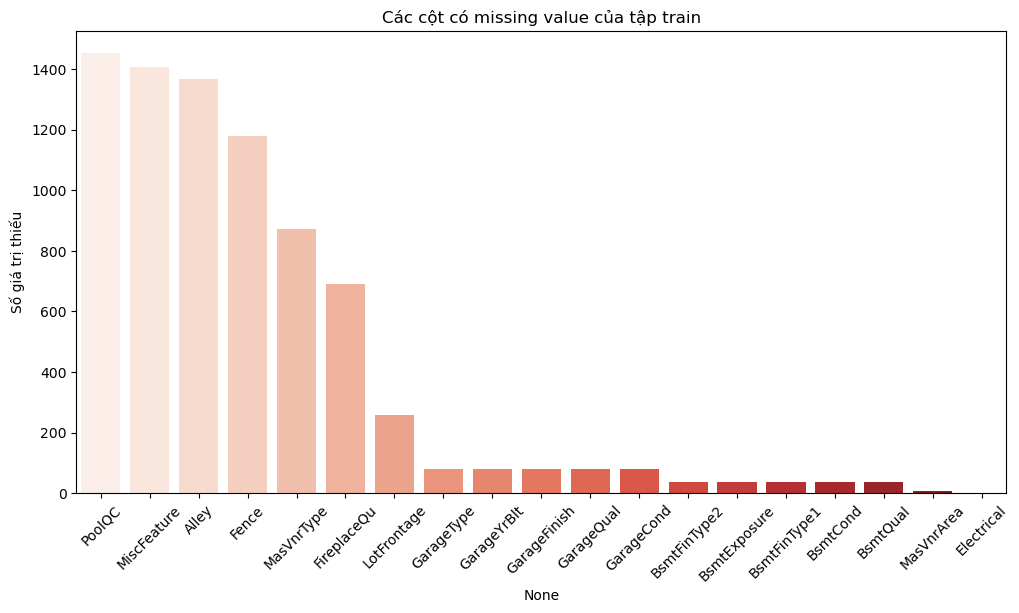

In [180]:
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=missing.index, y=missing.values, palette="Reds")
plt.xticks(rotation=45)  # xoay nhãn cho vừa
plt.ylabel("Số giá trị thiếu")
plt.title("Các cột có missing value của tập train")
plt.show()

In [181]:
display_missing_data(test_df)

              Giá trị thiếu  Phần trăm (%)
PoolQC                 1456          99.79
MiscFeature            1408          96.50
Alley                  1352          92.67
Fence                  1169          80.12
MasVnrType              894          61.27
FireplaceQu             730          50.03
LotFrontage             227          15.56
GarageCond               78           5.35
GarageYrBlt              78           5.35
GarageQual               78           5.35
GarageFinish             78           5.35
GarageType               76           5.21
BsmtCond                 45           3.08
BsmtExposure             44           3.02
BsmtQual                 44           3.02
BsmtFinType1             42           2.88
BsmtFinType2             42           2.88
MasVnrArea               15           1.03
MSZoning                  4           0.27
BsmtFullBath              2           0.14
BsmtHalfBath              2           0.14
Functional                2           0.14
Utilities  

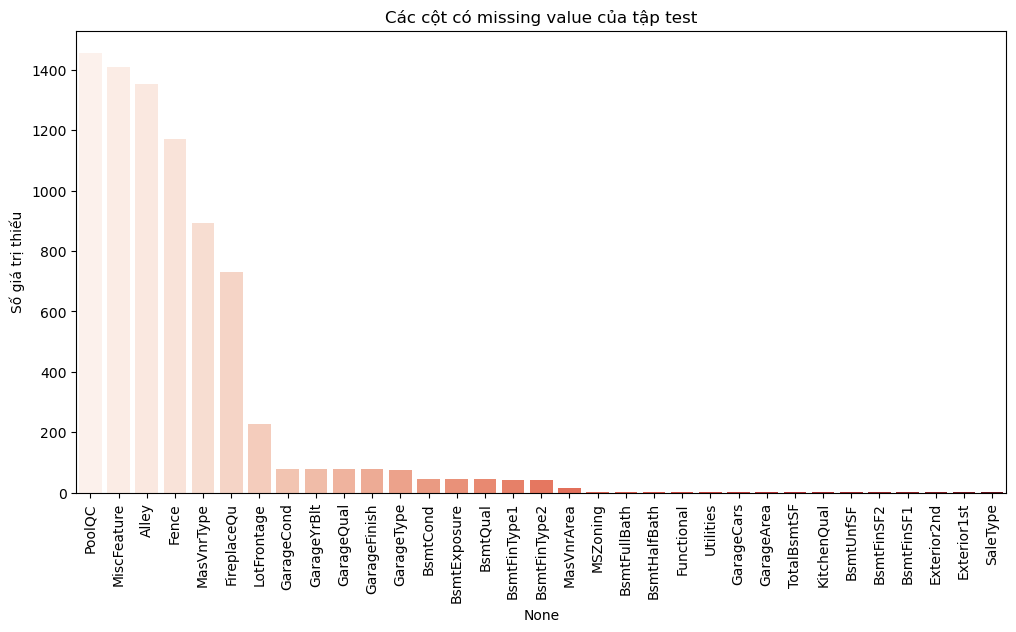

In [182]:
missing = test_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=missing.index, y=missing.values, palette="Reds")
plt.xticks(rotation=90)  # xoay nhãn cho vừa
plt.ylabel("Số giá trị thiếu")
plt.title("Các cột có missing value của tập test")
plt.show()

### Chi tiết các cột dữ liệu bị thiếu và giá trị

#### 1. Mặt tiền & lô đất
- **LotFrontage**: 259 giá trị thiếu → độ dài mặt tiền kết nối với đường.  
  Ví dụ giá trị phổ biến: 60, 70, 80, 50… NaN → chưa ghi thông tin.

#### 2. Hẻm
- **Alley**: 1369 giá trị thiếu → nhiều nhà không có hẻm  
  - `Grvl` → hẻm sỏi  
  - `Pave` → hẻm trải nhựa  
  - `NaN` → không có hẻm

#### 3. Ốp tường & vật liệu xây dựng
- **MasVnrType**: 872 giá trị thiếu → loại ốp mặt ngoài  
  - `BrkFace` → gạch mặt  
  - `Stone` → đá  
  - `BrkCmn` → gạch thường  
  - `NaN` → không có ốp
- **MasVnrArea**: 8 giá trị thiếu → diện tích ốp ngoài (square feet)  
  - 0 → không có ốp  
  - Các giá trị khác: 108, 72, 180…  
  - NaN → chưa ghi thông tin

#### 4. Tầng hầm
- **BsmtQual**: 37 giá trị thiếu → chất lượng tầng hầm (`Ex`, `Gd`, `TA`, `Fa`, NaN)  
- **BsmtCond**: 37 giá trị thiếu → tình trạng tầng hầm (`TA`, `Gd`, `Fa`, `Po`, NaN)  
- **BsmtExposure**: 38 giá trị thiếu → ánh sáng / tiếp xúc ngoài (`No`, `Av`, `Gd`, `Mn`, NaN)  
- **BsmtFinType1**: 37 giá trị thiếu → chất lượng diện tích tầng hầm (`GLQ`, `ALQ`, `BLQ`, `Rec`, `LwQ`, `Unf`, NaN)  
- **BsmtFinType2**: 38 giá trị thiếu → chất lượng diện tích thứ 2 tầng hầm (`GLQ`, `ALQ`, `BLQ`, `Rec`, `LwQ`, `Unf`, NaN)

#### 5. Điện
- **Electrical**: 1 giá trị thiếu → hệ thống điện  
  - `SBrkr` → cầu dao, phổ biến nhất  
  - `FuseA`, `FuseF`, `FuseP`, `Mix`  
  - NaN → chưa ghi thông tin

#### 6. Lò sưởi
- **FireplaceQu**: 690 giá trị thiếu → chất lượng lò sưởi  
  - `Ex`, `Gd`, `TA`, `Fa`, `Po`, NaN → nhiều nhà không có lò sưởi

#### 7. Gara
- **GarageType**: 81 giá trị thiếu → kiểu gara (`Attchd`, `Detchd`, `BuiltIn`, `Basment`, `CarPort`, `2Types`, NaN)  
- **GarageYrBlt**: 81 giá trị thiếu → năm xây gara  
- **GarageFinish**: 81 giá trị thiếu → hoàn thiện gara (`Fin`, `RFn`, `Unf`, NaN)  
- **GarageQual**: 81 giá trị thiếu → chất lượng gara (`Ex`, `Gd`, `TA`, `Fa`, `Po`, NaN)  
- **GarageCond**: 81 giá trị thiếu → tình trạng gara (`Ex`, `Gd`, `TA`, `Fa`, `Po`, NaN)

#### 8. Hồ bơi
- **PoolQC**: 1453 giá trị thiếu → chất lượng hồ bơi (`Ex`, `Gd`, `Fa`, NaN)  
  - Hầu hết nhà không có hồ bơi → NaN

#### 9. Hàng rào
- **Fence**: 1179 giá trị thiếu → chất lượng hàng rào (`MnPrv`, `GdPrv`, `GdWo`, `MnWw`, NaN)  
  - Nhiều nhà không có hàng rào → NaN

#### 10. Tính năng phụ
- **MiscFeature**: 1406 giá trị thiếu → các tính năng phụ  
  - `Shed` → nhà kho / chuồng nhỏ  
  - `Gar2` → gara thứ 2  
  - `Othr` → khác  
  - `TenC` → sân tennis  
  - `NaN` → không có tính năng phụ


### Phân tích biến mục tiêu: `SalePrice`

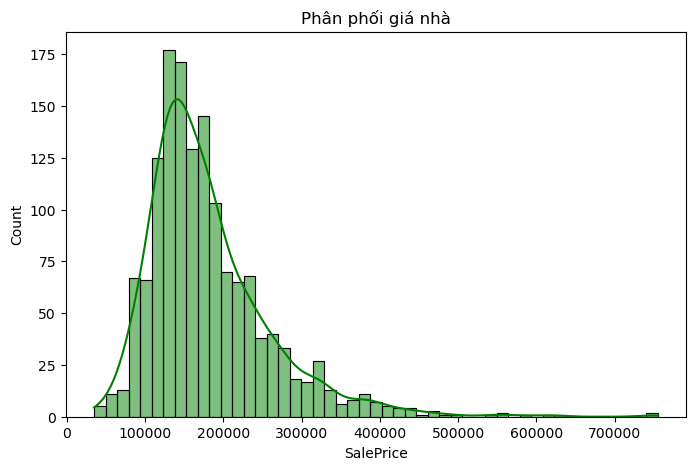

In [183]:
plt.figure(figsize=(8,5))
sns.histplot(train_df['SalePrice'], kde=True, color='green')
plt.title('Phân phối giá nhà')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show()

**Nhận xét:**
Biểu đồ phân phối cho thấy SalePrice bị lệch phải (right-skewed). Hầu hết các căn nhà tập trung ở mức giá thấp đến trung bình, và có một "đuôi dài" gồm các căn nhà rất đắt tiền.

In [184]:
# Tính skew
saleprice_skew = skew(train_df['SalePrice'])
print(f"Skewness của SalePrice: {saleprice_skew:.2f}")

Skewness của SalePrice: 1.88


**Nhận xét:** Skewness của biến SalePrice là 1.88 (>1), cho thấy phân phối lệch phải khá mạnh. Giải pháp hợp lý là biến đổi **logarit (log(SalePrice))**, giúp giảm độ lệch và làm phân phối gần chuẩn hơn.

### Phân loại biến
- **Kiểu số (numeric):**  38 cột (diện tích, số lượng, năm, giá trị, giá bán).

- **Kiểu phân loại (categorical):** 43 cột (mô tả đặc điểm, vật liệu, vị trí, tiện nghi, điều kiện bán).

In [185]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

print(f"Số cột numeric: {len(numeric_features)}")
print(list(numeric_features))
print(f"Số cột categorical: {len(categorical_features)}")
print(list(categorical_features))

Số cột numeric: 38
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
Số cột categorical: 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Firepla

1. **`Biến số (Numeric) – 38 cột`**

- **Liên tục (Continuous):** 
LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF,
1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, GarageArea,
WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch,
PoolArea, MiscVal, SalePrice

- **Rời rạc (Discrete / Count):** 
OverallQual, OverallCond, YearBuilt, YearRemodAdd,
BsmtFullBath, BsmtHalfBath, FullBath, HalfBath,
BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces,
GarageCars, GarageYrBlt, MoSold, YrSold

2. **`Biến phân loại (Categorical) – 43 cột`**

- **Vị trí & quy hoạch:** 
MSSubClass, MSZoning, Neighborhood, Condition1, Condition2,
LotConfig, LandContour, LandSlope, Street, Alley

- **Kiến trúc & cấu trúc:** 
BldgType, HouseStyle, RoofStyle, RoofMatl,
Exterior1st, Exterior2nd, MasVnrType, Foundation,
ExterQual, ExterCond, OverallQual, OverallCond

- **Tầng hầm:** 
BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

- **Gara:** 
GarageType, GarageFinish, GarageQual, GarageCond

- **Nội thất & tiện nghi:** 
Heating, HeatingQC, CentralAir, Electrical, KitchenQual,
Functional, FireplaceQu, PavedDrive, Fence, PoolQC, MiscFeature

- **Giao dịch:** 
SaleType, SaleCondition

#### Categorical features

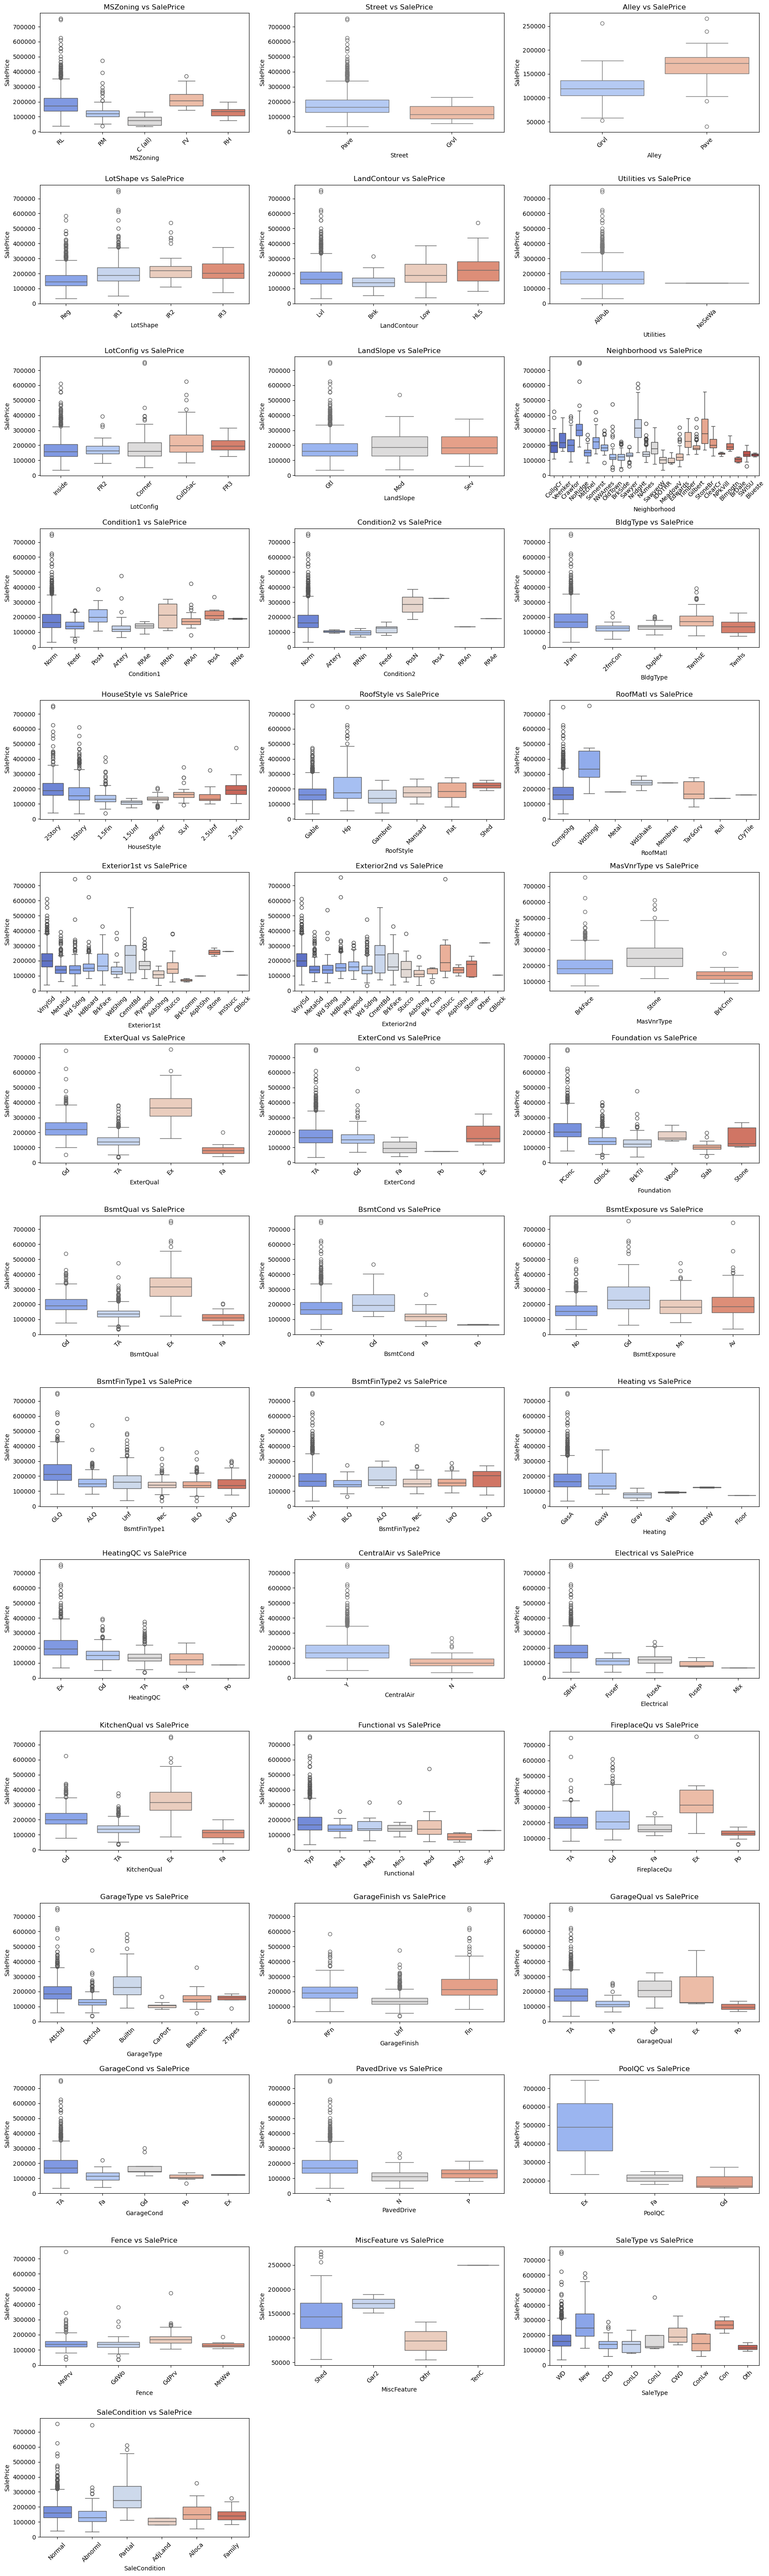

In [186]:
n_feats = len(categorical_features)
n_cols = 3
n_rows = (n_feats + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
ax = ax.flatten()

for i, col in enumerate(categorical_features):
    sns.boxplot(
        data=train_df,
        x=col,
        y='SalePrice',
        palette='coolwarm',
        ax=ax[i]
    )
    ax[i].set_title(f'{col} vs SalePrice')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('SalePrice')
    ax[i].tick_params(axis='x', rotation=45)  # xoay label cho dễ đọc

# Ẩn ô trống nếu có
for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

**1. Biến liên quan đến vị trí & khu vực**

- `Neighborhood` có ảnh hưởng rõ rệt đến giá bán – một số khu như NridgHt, NoRidge, StoneBr có giá trung bình cao hơn hẳn.

- `MSZoning` cũng có khác biệt — khu RL (Residential Low Density) thường có giá cao nhất.

- `Street`, `Alley`, `LandSlope`, `LotConfig`, `Condition1/2` hầu như ít ảnh hưởng, giá phân bố khá tương đồng giữa các nhóm.

**2. Biến về kiến trúc & cấu trúc nhà**

- `HouseStyle` và `BldgType`: kiểu nhà 1Story, 2Story có giá cao hơn Duplex hoặc 1.5Unf.

- `RoofStyle`, `RoofMatl` không có xu hướng nổi bật → có thể ảnh hưởng yếu, cân nhắc loại bỏ.

- `Exterior1st`, `Exterior2nd`, `Foundation`: một số loại như PConc (móng bê tông) có giá cao hơn nhóm khác.

- `MasVnrType`: nhà có ốp đá (Stone) thường có giá cao hơn None hoặc BrkFace.

**3. Biến về chất lượng & vật liệu**

- `ExterQual` và `ExterCond` thể hiện tương quan mạnh với SalePrice – chất lượng tốt (Ex, Gd) có giá cao hơn rõ.

- `KitchenQual` cũng cho xu hướng tương tự – Excellent có giá cao vượt trội.

- `HeatingQC` cũng tương quan khá tốt – hệ thống sưởi chất lượng cao đi kèm giá nhà cao.

- `Functional` đa phần tập trung ở mức Typ (bình thường) → ít ảnh hưởng lớn đến giá.

**4. Biến về tầng hầm**

- `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1` đều ảnh hưởng rõ rệt đến SalePrice – nhà có tầng hầm tốt, thông thoáng, hoàn thiện cao thường có giá bán cao hơn.

- `BsmtFinType2` thì ít ảnh hưởng rõ.

**5. Biến về gara**

- `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`: các loại gara hoàn thiện cao, trong nhà (Attchd, BuiltIn) thường có giá cao hơn.

- Chất lượng gara tốt (Ex, Gd) cũng đi kèm giá bán cao hơn.

**6. Biến về tiện nghi khác**

- `FireplaceQu`: nhà có lò sưởi chất lượng tốt (Ex, Gd) có giá cao hơn rõ.

- `Fence`, `PoolQC`, `MiscFeature`: dữ liệu ít và phân bố không đều → ít ảnh hưởng hoặc cần xem xét bỏ.

- `PavedDrive`: nhà có đường lái xe lát gạch (Y) có xu hướng giá cao hơn.

**7. Biến về giao dịch**

- `SaleType` và `SaleCondition`: loại giao dịch New và tình trạng Partial thường gắn với nhà mới, giá cao; trong khi Abnorml và Family có giá thấp hơn trung bình.

- **Tóm lại:**

Những biến phân loại có tác động mạnh nhất đến giá nhà trong dataset HousePrices gồm:
`Neighborhood`, `OverallQual`, `ExterQual`, `KitchenQual`, `BsmtQual`, `GarageFinish`, `GarageType`, `FireplaceQu`, `SaleCondition`.

#### Numeric features

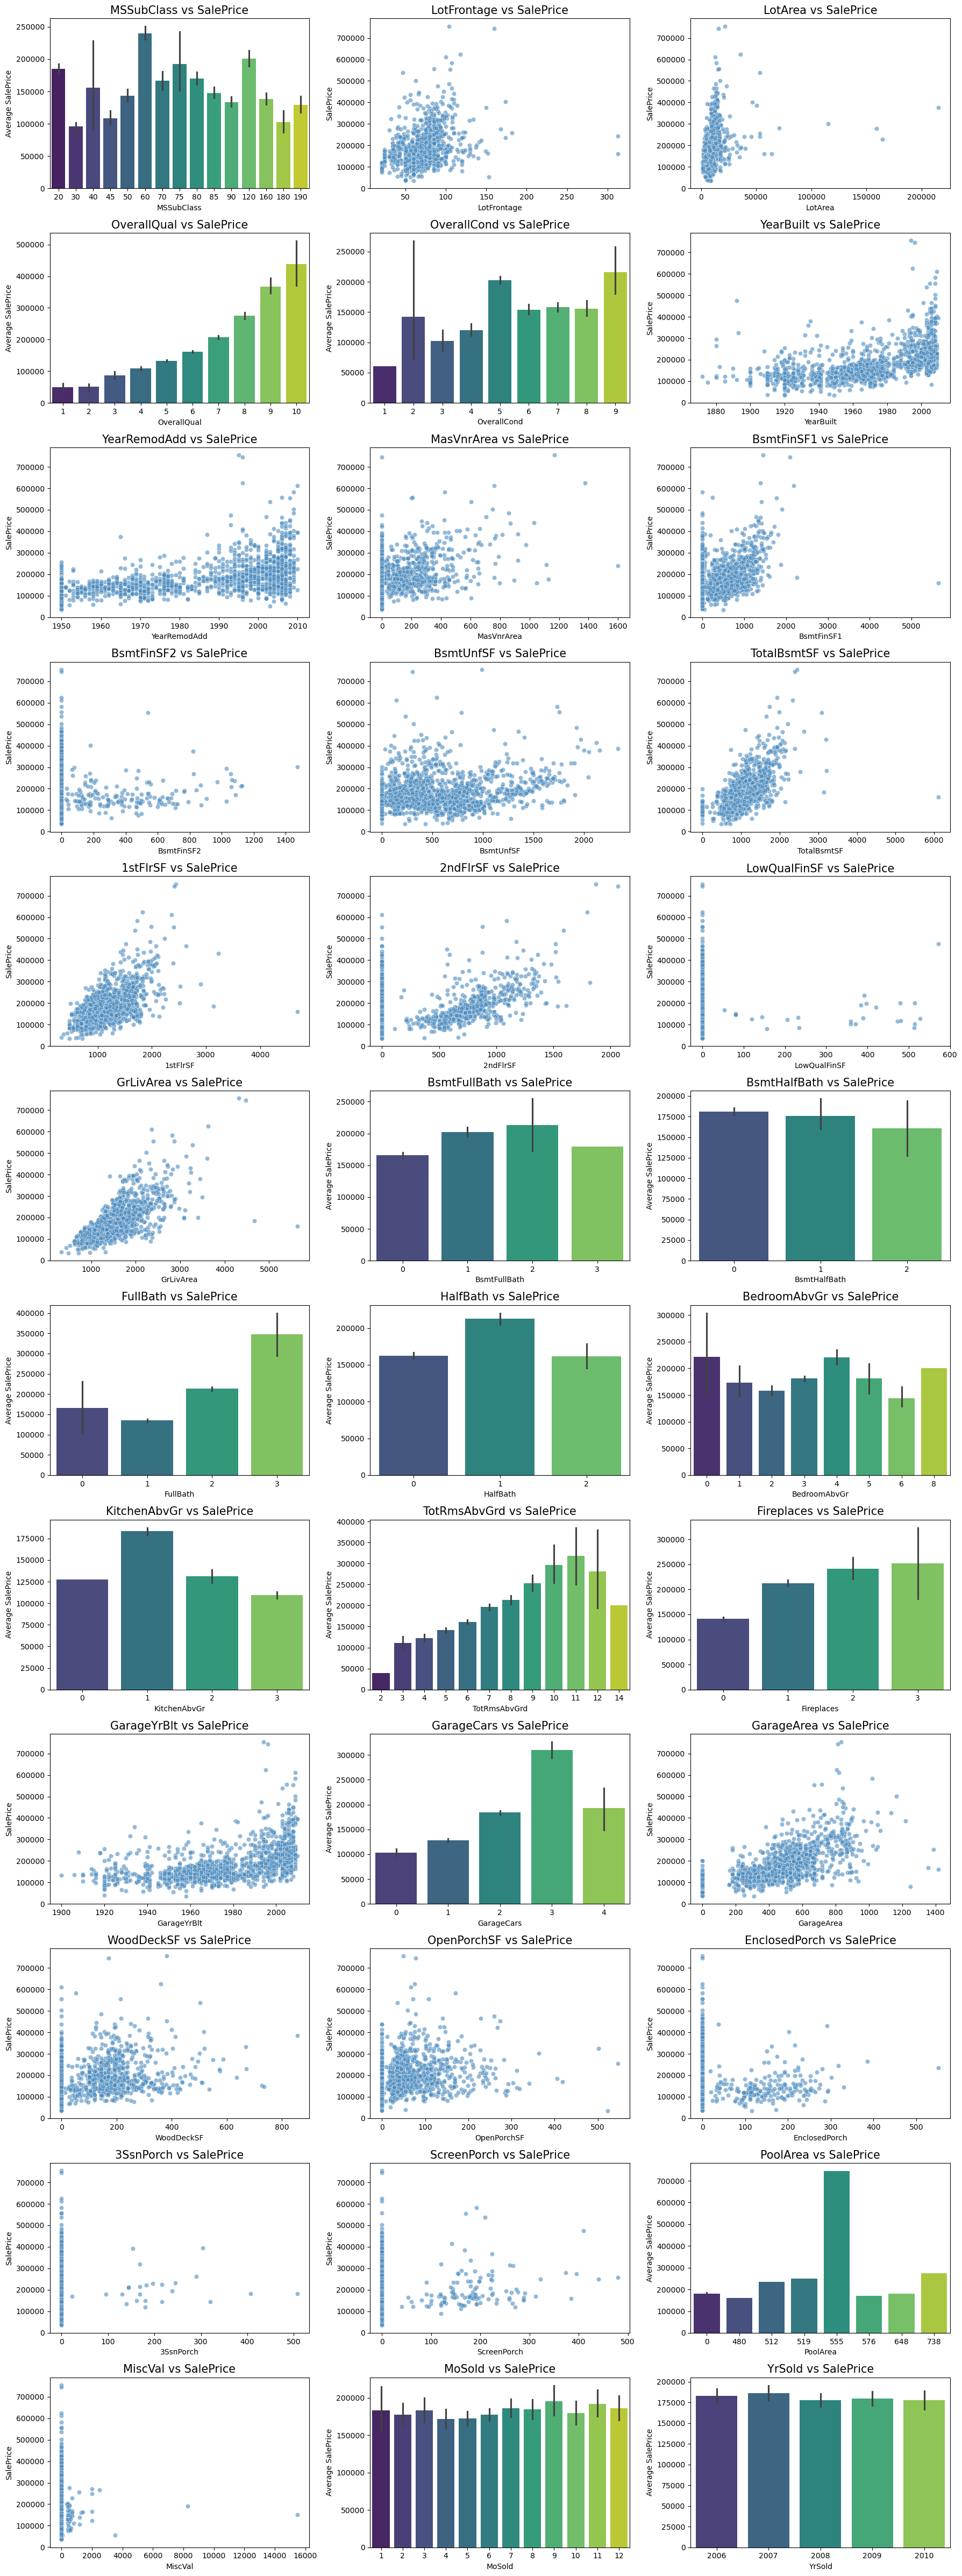

In [187]:
num_feats = [col for col in numeric_features if col not in ['Id', 'SalePrice']]

n_feats = len(num_feats)
n_cols = 3
n_rows = (n_feats + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))  # to rõ
ax = ax.flatten()

for i, col in enumerate(num_feats):
    if train_df[col].nunique() < 20:
        # Biến numeric ít giá trị: barplot (trung bình SalePrice)
        sns.barplot(
            data=train_df,
            x=col,
            y='SalePrice',
            palette='viridis',
            ax=ax[i],
            estimator='mean'
        )
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('Average SalePrice')
    else:
        # Biến numeric liên tục: scatterplot
        sns.scatterplot(
            data=train_df,
            x=col,
            y='SalePrice',
            color='#4B8BBE',
            alpha=0.6,
            ax=ax[i]
        )
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('SalePrice')
    
    ax[i].set_title(f'{col} vs SalePrice', fontsize=15)

# Ẩn các ô trống nếu số biến không chia hết cho grid
for j in range(i + 1, len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

**Các biến có tương quan mạnh với SalePrice:**

- `OverallQual`, `GrLivArea`, `GarageCars`, `TotalBsmtSF`, `1stFlrSF`, `FullBath` → cho thấy nhà lớn hơn, chất lượng cao hơn → giá cao hơn rõ rệt.

- `YearBuilt`, `YearRemodAdd` → nhà mới hoặc được sửa lại gần đây có xu hướng bán giá cao hơn.

**Các biến có tương quan trung bình:**

- `GarageArea`, `TotRmsAbvGrd`, `Fireplaces`, `LotArea` → ảnh hưởng đến giá nhưng không quá rõ ràng hoặc có vài điểm ngoại lệ.

- `OpenPorchSF`, `WoodDeckSF`, `MasVnrArea` → ảnh hưởng nhẹ, nhưng nhà có tiện ích ngoài trời thường có giá nhỉnh hơn.

**Các biến ít ảnh hưởng hoặc phân tán mạnh:**

- `BsmtFinSF2`, `LowQualFinSF`, `3SsnPorch`, `PoolArea`, `MiscVal` → gần như không có tương quan với giá (hầu hết bằng 0 hoặc rất ít giá trị khác biệt).

- `LotFrontage` có xu hướng phân tán cao → không ổn định, cần chuẩn hoá hoặc xử lý ngoại lệ.

**Phát hiện đặc biệt:**

- Một số biến như `GarageYrBlt` hoặc `YrSold` không ảnh hưởng nhiều – dữ liệu trải dài và không có xu hướng giá rõ rệt.

- `SalePrice` tăng gần như tuyến tính với các đặc trưng diện tích (`GrLivArea`, `TotalBsmtSF`, `1stFlrSF`).

**Tóm lại:**

- Các đặc trưng diện tích, chất lượng tổng thể và năm xây dựng có mối tương quan mạnh với giá nhà.
- Một số biến nhỏ như diện tích hồ bơi, tầng thấp hoặc diện tích hầm phụ không ảnh hưởng đáng kể.
- Cần chuẩn hoá các biến có độ phân tán cao (`LotArea`, `LotFrontage`) và xem xét loại bỏ hoặc mã hoá đặc trưng yếu.

##### Ma trận tương quan của Numeric features

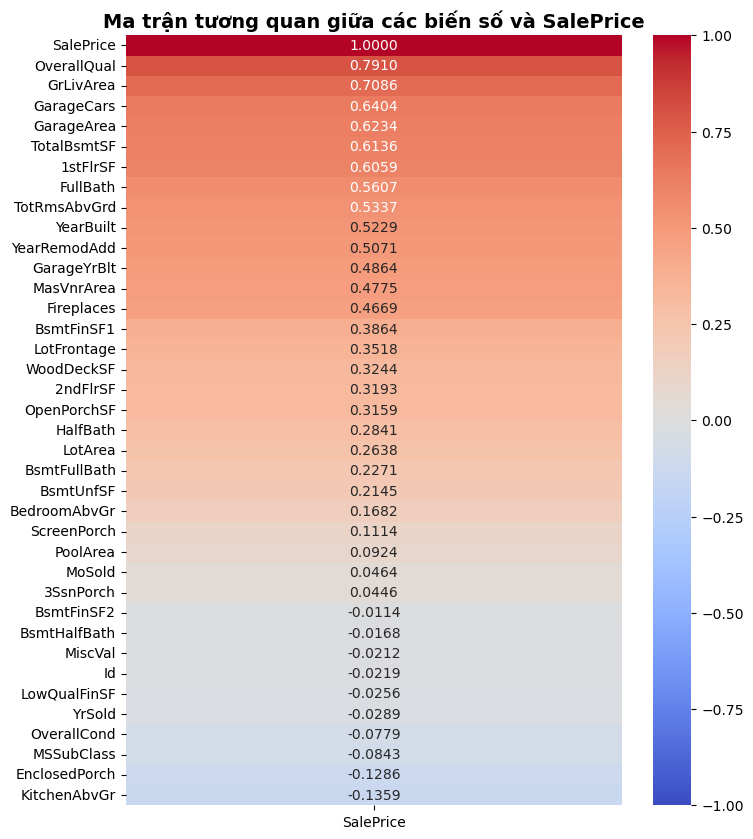

In [188]:
# Chọn các biến numeric
numeric_features = train_df.select_dtypes(include=['int64', 'float64'])
# Ma trận tương quan
corr = numeric_features.corr()
# ---- Vẽ riêng tương quan với SalePrice ----
plt.figure(figsize=(8, 10))
saleprice_corr = corr['SalePrice'].sort_values(ascending=False).to_frame()

sns.heatmap(saleprice_corr, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".4f", 
            vmin=-1, vmax=1)
plt.title("Ma trận tương quan giữa các biến số và SalePrice", fontsize=14, fontweight='bold')
plt.show()

## Preprocessing data

### Gộp tập train và test để xử lý đồng bộ

In [189]:
train_rows = train_df.shape[0]
all_data = pd.concat([train_df.drop(['SalePrice'], axis=1), test_df], sort=False).reset_index(drop=True)
print("All data shape:", all_data.shape)

All data shape: (2919, 80)


- Biến `train_rows` dùng để ghi nhớ ranh giới giữa dữ liệu train và test.

- Việc gộp train & test giúp xử lý dữ liệu nhất quán (fill missing, encoding, scaling, feature engineering...) mà không bị lệch định dạng giữa hai tập.

### Filling missing values

> **Mục tiêu:** Xử lý các giá trị NaN trong all_data sao cho dữ liệu không còn giá trị thiếu (NaN) trước khi encode / scale.

In [190]:
# Nhóm các cột có giá trị NA mang ý nghĩa là "không có"
categorical_na_cols = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType'
]

# Nhóm các cột numeric mà NA mang ý nghĩa là 0
numerical_na_to_zero = [
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'PoolArea', 'MiscVal'
]

# Điền giá trị đặc biệt trước
for col in numerical_na_to_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

for col in categorical_na_cols:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

# Điền tự động phần còn lại
# Các cột dạng object → 'None'
for col in all_data.select_dtypes(include=['object']).columns:
    if all_data[col].isnull().sum() > 0:
        all_data[col] = all_data[col].fillna('None')

# Các cột numeric → median
for col in all_data.select_dtypes(include=[np.number]).columns:
    if all_data[col].isnull().sum() > 0:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# Quick check
print("Remaining missing values after fills:", all_data.isnull().sum().sum())

Remaining missing values after fills: 0


**Phân loại rõ nhóm cột để điền các dữ liệu thiếu hợp lý.**
- Categorical NA → 'None' vì giá trị 'NaN' ở đây không phải do nhập thiếu, mà là do nhà đó không có phần đó.
- Numeric NA → 0 vì khi nhà không có phần đó, thì diện tích hoặc số lượng = 0 là đúng về mặt thực tế.
Nếu ta để 'NaN' hoặc điền median (số dương) → sai ngữ cảnh hoàn toàn..

**Phần còn lại:**

- Với categorical → 'None' để đảm bảo không lỗi khi mã hóa.
- Với numeric → median để giảm ảnh hưởng của outliers.

**Cuối cùng, xác minh không còn missing nào trong all_data thì mới đến các bước thực hiện tiếp theo.**

## Feature Engineering

- Tạo ra các đặc trưng tổng hợp phản ánh quy mô và tiện ích thật sự của ngôi nhà — điều mà `SalePrice` (giá nhà) có quan hệ rất mạnh.

In [191]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] 
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']  # tổng diện tích hiên/ban công
all_data['TotalBath'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath']  # tổng số phòng tắm
all_data['TotalRooms'] = all_data['TotRmsAbvGrd'] + all_data['FullBath'] + all_data['HalfBath']            # tổng số phòng có thể sử dụng
all_data['TotalSpace'] = all_data['TotalSF'] + all_data['GarageArea'] + all_data['TotalPorchSF']           # tổng không gian sử dụng (bao gồm garage và porch)

all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)             # có hồ bơi không
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)      # có lò sưởi không
all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)         # có garage không
all_data['HasBsmt'] = (all_data['TotalBsmtSF'] > 0).astype(int)          # có tầng hầm không
all_data['HasPorch'] = (all_data['TotalPorchSF'] > 0).astype(int)  

- `TotalSF`: Tổng diện tích sàn của căn nhà → cộng tổng diện tích tầng hầm + tầng 1 + tầng 2. Giúp mô hình hiểu quy mô tổng thể của ngôi nhà (to hơn → giá cao hơn).
- `TotalPorchSF`: Tổng diện tích hiên, ban công, sân thượng → cộng toàn bộ diện tích các loại 'porch' (nhà có nhiều không gian ngoài trời thường có giá cao hơn).
- `TotalBath`: Tổng số phòng tắm → cộng phòng tắm đầy đủ (có bồn, vòi sen, toilet) + phòng tắm chỉ có toilet + bồn rửa + phòng tắm ở tầng hầm (BsmtFullBath, BsmtHalfBath). Tổng hợp thành thước đo của tổng tiện nghi tắm rửa trong nhà.
- `TotalRooms`: Tổng số phòng có thể sử dụng → cộng số phòng trên mặt đất + phòng tắm. Giúp mô hình ước lượng độ rộng rãi, quy mô.
- `TotalSpace`: Tổng không gian sử dụng → Tổng diện tích tất cả không gian mà chủ nhà có thể sử dụng hoặc tận dụng (diện tích sàn + garage + hiên). Mức tương quan với giá nhà thường rất cao.

**Các biến nhị phân 0/1: Đây là biến tiện ích giúp mô hình nhận biết có hay không có tiện nghi nhất định.**
- `HasPool`: Có hồ bơi không
- `HasFireplace`: Có lò sưởi không
- `HasGarage`: Có garage không
- `HasBsmt`: Có tầng hầm không
- `HasPorch`: Có hiên/ban công không

**→ Giúp mô hình hiểu rõ hơn về sự hiện diện của các tiện ích lớn ảnh hưởng đến giá**

**Nhận xét:**
- Nhờ **`Feature Engineering`**, dữ liệu thô đã được mở rộng thành các đặc trưng có ý nghĩa thống kê và thực tế.

- Các biến tổng hợp cung cấp thước đo tổng thể về quy mô và tiện nghi, trong khi biến nhị phân giúp mô hình học được sự hiện diện của các yếu tố ảnh hưởng trực tiếp đến giá trị tài sản.

### Encoding

**Mục tiêu:** Chuẩn hoá (scale) các biến số (numeric) và mã hóa (one-hot) các biến phân loại (categorical) theo một pipeline reproducible (dùng sklearn). Đảm bảo train và test được xử lý giống hệt nhau (không bị mismatch column sau khi one-hot).

In [192]:
numeric_feats = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_feats = [c for c in numeric_feats if c not in ['Id', 'SalePrice']]  # loại cột không dùng

categorical_feats = all_data.select_dtypes(include=['object']).columns.tolist()

**Xác định feature numeric / categorical:** Để tách dữ liệu ra làm 2 nhóm chính trước khi xử lý vì 2 loại feature này cần xử lý khác nhau.

In [193]:
onehot_cols = [c for c in categorical_feats if all_data[c].nunique() <= 50]

**Giới hạn one-hot bằng ngưỡng cardinality:** vì one-hot cho cột có nhiều category (cardinality cao) gây bùng nổ chiều (dimensional explosion) → tốn RAM, dễ overfit.

In [194]:
# Chia lại train/test
train_len = len(train_df)
train_processed = all_data.iloc[:train_len, :].copy()
test_processed = all_data.iloc[train_len:, :].copy()
# Target
y = np.log1p(train_df['SalePrice']).values

- Sau khi gộp **all_data** để xử lý missing/feature engineering, cần tách lại tập **train** và **test** bằng **train_len**.

- `np.log1p` cho `SalePrice` vì target lệch phải (log transform giúp mô hình ổn định & giảm ảnh hưởng outliers).

In [195]:
# Tạo pipeline cho numeric và categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kết hợp lại bằng ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feats),
        ('cat', categorical_transformer, onehot_cols)
    ],
    remainder='drop'
)

**Xây dựng pipeline xử lý dữ liệu tự động cho numeric và categorical features.**

- `Numeric`: Điền giá trị thiếu bằng median để giảm ảnh hưởng của outlier.
- `Categorical`: Điền missing bằng 'None' và mã hoá one-hot để mô hình hiểu dạng phân loại.
- Kết hợp bằng ColumnTransformer để áp dụng chính xác pipeline cho từng nhóm cột.

Pipeline giúp tự động hoá toàn bộ quá trình xử lý dữ liệu cho cả train và test — đảm bảo quy trình xử lý dữ liệu được fit một lần trên tập huấn luyện và áp dụng y hệt lên tập kiểm thử, giúp mô hình tổng quát hoá tốt hơn, tránh sai lệch do khác biệt tiền xử lý.

- Fit & transform dữ liệu

In [196]:
print("Fitting preprocessor...")
x_train = preprocessor.fit_transform(train_processed)
x_test = preprocessor.transform(test_processed)

Fitting preprocessor...


**Áp dụng pipeline đã tạo (preprocessor) lên dữ liệu thực tế.**

**`fit_transform` trên train:**

- Học các tham số từ train (median, danh sách category, one-hot columns).
- Đồng thời transform train thành ma trận đặc trưng cuối cùng.

**`transform` trên test:**

- Sử dụng các tham số đã học từ train để biến đổi test.
- Không học thêm từ test → tránh data leakage.

## Models Training and Evaluation

- `LinearRegression`: Mô hình hồi quy tuyến tính cơ bản, dự đoán giá trị bằng tổng trọng số của các feature.

- `Random Forest`: Mô hình ensemble dựa trên nhiều cây quyết định (decision tree). Kết quả là trung bình (regression) của các cây để tăng tính ổn định và giảm overfitting.

- `Gradient Boosting`: Mô hình boosting tuần tự, mỗi cây mới học để giảm lỗi của cây trước đó. Giúp capture quan hệ phi tuyến và interaction giữa các biến.

- `XGBoost`: Biến thể tối ưu của gradient boosting, nhanh hơn, có regularization L1/L2, khả năng xử lý missing tốt và kiểm soát overfitting hiệu quả.

- `CatBoost`: Gradient boosting tối ưu cho dữ liệu có nhiều biến phân loại (categorical), tự động xử lý categorical, ít cần tiền xử lý.

- `SVR` (Support Vector Regression): Mô hình regression dựa trên ý tưởng của SVM, cố gắng tìm một “tube” quanh dữ liệu và chỉ quan tâm đến điểm ngoài tube. Kiểm soát tốt non-linear relationship với kernel.

In [197]:
models = {
    'LinearRegression': LinearRegression(),

    'RandomForest': RandomForestRegressor(
        n_estimators=600, max_depth=10, min_samples_split=5, 
        min_samples_leaf=4, random_state=RANDOM_STATE, n_jobs=-1
    ),

    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE
    ),

    'XGBoost': XGBRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=3,
        subsample=0.7, colsample_bytree=0.7, reg_lambda=1,
        random_state=RANDOM_STATE
    ),

    'CatBoost': CatBoostRegressor(
        iterations=1000, learning_rate=0.05, depth=6,
        random_state=42, verbose=False,
        allow_writing_files=False, train_dir=None
    ),

    'SVR': SVR(kernel='rbf', C=30, gamma=0.01, epsilon=0.1)
}


- **Tham số của mô hình:**

> **LinearRegression**
- Baseline tuyến tính, không regularization.
> **Random Forest**
- n_estimators=600: số cây nhiều → giảm variance.
- max_depth=10: giới hạn độ sâu để tránh overfit.
- min_samples_split=5 / min_samples_leaf=4: tăng tính ổn định, tránh cây học quá chi tiết.
- n_jobs=-1: dùng toàn bộ CPU.
> **Gradient Boosting**
- learning_rate=0.05: nhỏ → học chậm nhưng ổn định.
- n_estimators=300: đủ để học các patterns.
- max_depth=3: cây nông, tránh overfit.
> **XGBoost**
- learning_rate=0.05: nhỏ → học chậm nhưng ổn định.
- n_estimators=1000: số lượng cây boosting, nhiều cây + learning_rate nhỏ giúp capture patterns chi tiết hơn.
- max_depth=3: cây nông, tránh overfit.
- subsample=0.7: lấy 70% sample cho mỗi cây → giảm overfitting.
- colsample_bytree=0.7: chỉ dùng 70% feature cho mỗi cây → tăng diversity, giảm overfit.
- reg_lambda=1: regularization L2 để ổn định.
> **CatBoost**
- iterations=1000, learning_rate=0.05, depth=6: balance giữa bias và variance.
- verbose=False, allow_writing_files=False: tránh in ra log hoặc tạo folder trên hệ thống.
> **SVR**
- C=30 → vừa phải, tránh overfit
- gamma=0.01 → kiểm soát độ nhạy.
- Epsilon=0.1 → giới hạn sai số cho tube margin.

In [198]:
def rmse_cv(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

- Hàm `rmse_cv` dùng để đánh giá hiệu suất của mô hình regression theo metric RMSE (Root Mean Squared Error), sử dụng K-fold cross-validation.

- Giúp biết mức độ ổn định và generalization của mô hình trên dữ liệu chưa thấy (test-like).

In [199]:
results = {}
for name, model in models.items():
    print(f"Training & CV for {name} ...")
    scores = rmse_cv(model, x_train, y, cv=5)
    print(f"{name} CV RMSE (log target): {scores.mean():.5f} ± {scores.std():.5f}")
    results[name] = scores.mean()

fitted_models = {}
for name, model in models.items():
    print(f"Fitting {name} on full training data ...")
    model.fit(x_train, y)
    fitted_models[name] = model

Training & CV for LinearRegression ...
LinearRegression CV RMSE (log target): 0.16677 ± 0.03954
Training & CV for RandomForest ...
RandomForest CV RMSE (log target): 0.14134 ± 0.01810
Training & CV for GradientBoosting ...
GradientBoosting CV RMSE (log target): 0.12998 ± 0.01965
Training & CV for XGBoost ...
XGBoost CV RMSE (log target): 0.12584 ± 0.01659
Training & CV for CatBoost ...
CatBoost CV RMSE (log target): 0.12391 ± 0.01614
Training & CV for SVR ...
SVR CV RMSE (log target): 0.14451 ± 0.01115
Fitting LinearRegression on full training data ...
Fitting RandomForest on full training data ...
Fitting GradientBoosting on full training data ...
Fitting XGBoost on full training data ...
Fitting CatBoost on full training data ...
Fitting SVR on full training data ...


- **Đánh giá mô hình**: dùng hàm `rmse_cv` để tính RMSE trung bình ± độ lệch chuẩn qua 5-fold cross-validation cho từng mô hình.

- **Lưu kết quả**: Dictionary results chứa mean RMSE của từng mô hình để dễ so sánh.

- **Huấn luyện mô hình trên toàn bộ train (fit)**: chuẩn bị sẵn cho việc dự đoán trên test set.

## Xuất ra file kết quả

In [200]:
best_model_name = 'SVR'

try:
    if best_model_name not in fitted_models:
        raise ValueError(f"Model '{best_model_name}' chưa được train hoặc không tồn tại.")

    # Lấy model
    best_model = fitted_models[best_model_name]

    # Dự đoán trên test
    preds_log = best_model.predict(x_test)
    preds = np.expm1(preds_log)

    # Tạo file submission
    submission = pd.DataFrame({
        'Id': test_ID,
        'SalePrice': preds
    })
    submission.to_csv(f'submission_{best_model_name}.csv', index=False)
    print(f"File 'submission_{best_model_name}.csv' created using {best_model_name}.")

except Exception as e:
    print('Không thể tạo submission tự động:', e)

File 'submission_SVR.csv' created using SVR.


- Chọn mô hình tốt nhất (**best_model_name**) đã fit.
- Dự đoán giá nhà trên tập test.
- Xuất file .csv chuẩn format để submit (Id + SalePrice).

In [201]:
# !jupyter nbconvert --to script Code.ipynb

# Kết thúc